In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [3]:
TRAIN_DIR = './train/'
TEST_DIR = './test/'

In [4]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [5]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,./train/angry\Training_60894434.jpg,angry
1,./train/neutral\Training_50474020.jpg,neutral
2,./train/sad\Training_64215650.jpg,sad
3,./train/happy\Training_71123326.jpg,happy
4,./train/disgust\Training_31108028.jpg,disgust


In [6]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,./test/angry\PrivateTest_10131363.jpg,angry
1,./test/angry\PrivateTest_10304478.jpg,angry
2,./test/angry\PrivateTest_1054527.jpg,angry
3,./test/angry\PrivateTest_10590091.jpg,angry
4,./test/angry\PrivateTest_1109992.jpg,angry


<AxesSubplot:xlabel='label', ylabel='count'>

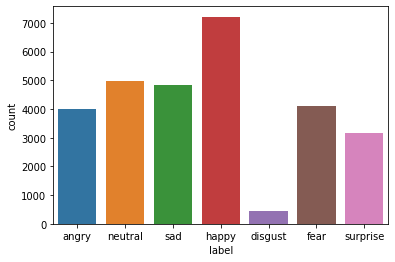

In [7]:
sns.countplot(train['label'])

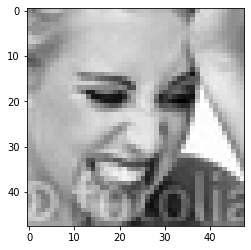

In [8]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

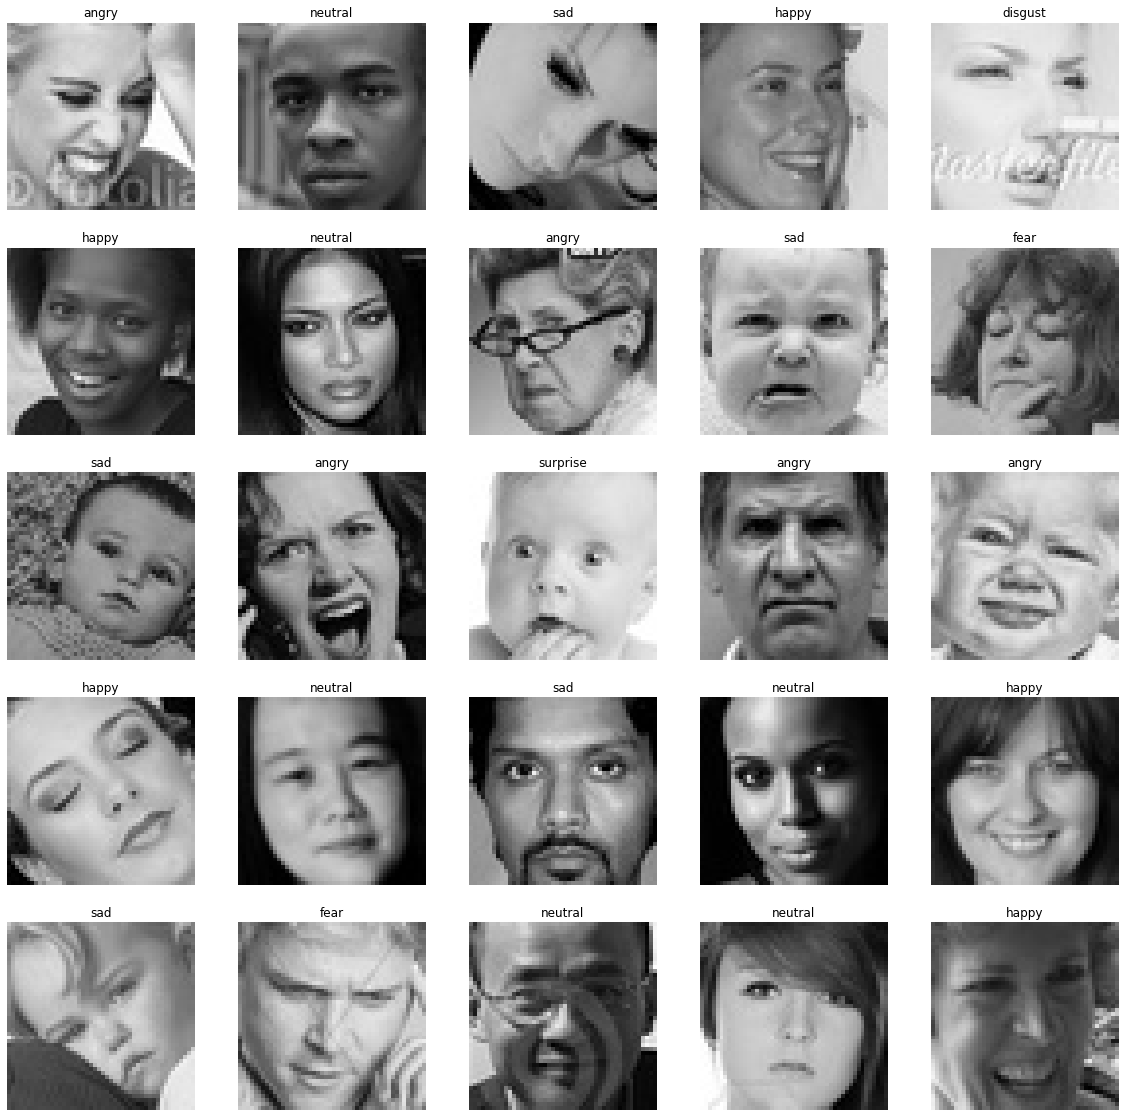

In [9]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [11]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [12]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [13]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [14]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [16]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [17]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [18]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [22]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 [==============================] - 329s 1s/step - loss: 1.8228 - accuracy: 0.2472 - val_loss: 1.8144 - val_accuracy: 0.2471
Epoch 2/100
225/225 [==============================] - 320s 1s/step - loss: 1.8005 - accuracy: 0.2548 - val_loss: 1.7602 - val_accuracy: 0.2379
Epoch 3/100
225/225 [==============================] - 327s 1s/step - loss: 1.7173 - accuracy: 0.2895 - val_loss: 1.6259 - val_accuracy: 0.3466
Epoch 4/100
225/225 [==============================] - 336s 1s/step - loss: 1.5988 - accuracy: 0.3656 - val_loss: 1.4515 - val_accuracy: 0.4288
Epoch 5/100
225/225 [==============================] - 326s 1s/step - loss: 1.4918 - accuracy: 0.4185 - val_loss: 1.3730 - val_accuracy: 0.4668
Epoch 6/100
225/225 [==============================] - 325s 1s/step - loss: 1.4259 - accuracy: 0.4485 - val_loss: 1.3134 - val_accuracy: 0.4872
Epoch 7/100
225/225 [==============================] - 326s 1s/step - loss: 1.3806 - accuracy: 0.4732 - val_loss: 1.2699 - val_accuracy:

In [23]:
model.save_weights('model.h5')

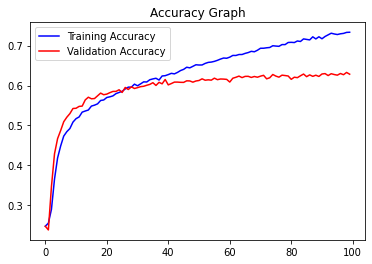

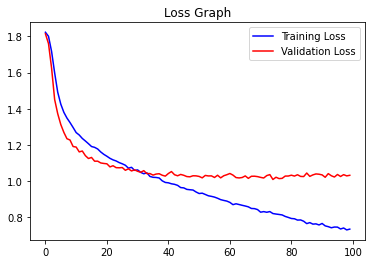

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

Original Output: fear
1/1 [==============================] - 0s 164ms/step
Predicted Output: fear


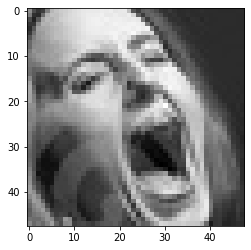

In [25]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 [==============================] - 0s 22ms/step
Predicted Output: neutral


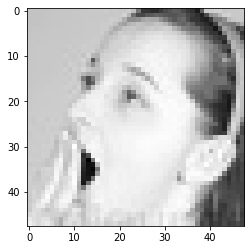

In [26]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 [==============================] - 0s 22ms/step
Predicted Output: happy


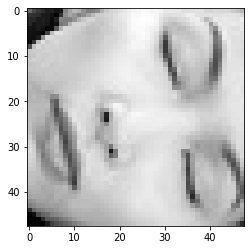

In [27]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');